In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
torch.cuda.empty_cache()
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
# import multiprocessing as mp
# mp.set_start_method('spawn')

In [3]:
# images_path = Path('./data/images')
# anno_path = Path('./')

In [4]:
# def filelist(root, file_type):
#     """Функция возвращает полностью квалифицированный список файлов в директории"""
#     return [os.path.join(directory_path, f) for directory_path, directory_name, 
#             files in os.walk(root) for f in files if f.endswith(file_type)]

# def generate_train_df (anno_path):
#     annotations = filelist(anno_path, '.xml')
#     anno_list = []
#     for anno_path in annotations:
#         root = ET.parse(anno_path).getroot()
#         anno = {}
#         anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
#         anno['width'] = root.find("./size/width").text
#         anno['height'] = root.find("./size/height").text
#         anno['class'] = root.find("./object/name").text
#         anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
#         anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
#         anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
#         anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
#         anno_list.append(anno)
#     return pd.DataFrame(anno_list)

In [5]:
df_train = pd.read_csv("./data/train_labels_.csv")
df_train.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [6]:
class_dict = {'raccoon': 0}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [7]:
df_train.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,0,95,60,167,118
1,raccoon-11.jpg,660,432,0,3,1,461,431
2,raccoon-63.jpg,600,400,0,74,107,280,290
3,raccoon-63.jpg,600,400,0,227,93,403,298
4,raccoon-60.jpg,273,185,0,58,33,197,127


### resize image

In [8]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [9]:
def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив обрамляющих прямоугольников из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])

In [10]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
#     im_resized = cv2.resize(im, (int(1.49*sz), sz))
#     Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    im_resized = cv2.resize(im, (int(1*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [11]:
new_paths = []
new_bbs = []
train_path_resized = Path('./data/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(Path('./data/' + row['filename']), train_path_resized, create_bb_array(row.values), 128)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [12]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,raccoon-17.jpg,259,194,0,95,60,167,118,data\images_resized\raccoon-17.jpg,"[39.0, 47.0, 77.0, 82.0]"
1,raccoon-11.jpg,660,432,0,3,1,461,431,data\images_resized\raccoon-11.jpg,"[0.0, 0.0, 127.0, 89.0]"
2,raccoon-63.jpg,600,400,0,74,107,280,290,data\images_resized\raccoon-63.jpg,"[34.0, 16.0, 92.0, 59.0]"
3,raccoon-63.jpg,600,400,0,227,93,403,298,data\images_resized\raccoon-63.jpg,"[30.0, 48.0, 95.0, 85.0]"
4,raccoon-60.jpg,273,185,0,58,33,197,127,data\images_resized\raccoon-60.jpg,"[22.0, 27.0, 87.0, 92.0]"


#### original img

In [13]:
im = cv2.imread('./data/'+ str(df_train.values[1][0]))
bb = create_bb_array(df_train.values[1])
print(im.shape)

(432, 660, 3)


In [14]:
Y = create_mask(bb, im)
mask_to_bb(Y)

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


array([  1.,   3., 430., 460.], dtype=float32)

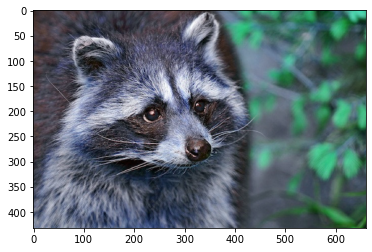

In [15]:
plt.imshow(im)

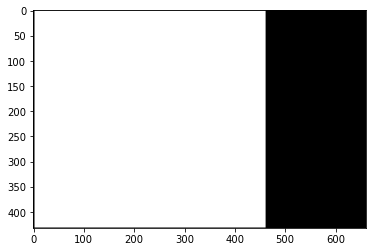

In [16]:
plt.imshow(Y, cmap='gray')

#### resized img

In [17]:
im = cv2.imread(str(df_train.values[1][8]))
bb = df_train.values[1][9]
print(im.shape)

(128, 128, 3)


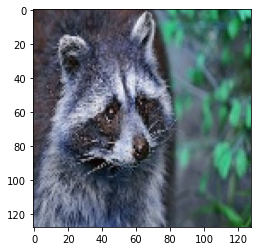

In [18]:
plt.imshow(im)

In [19]:
Y = create_mask(bb, im)
mask_to_bb(Y)

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


array([  0.,   0., 126.,  88.], dtype=float32)

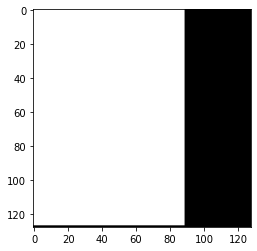

In [20]:
plt.imshow(Y, cmap='gray')

In [21]:
# train_path_resized

In [22]:
# im = read_image(Path('./data/' + str(df_train.values[1][0])))

In [23]:
# im_resized = cv2.resize(im, (int(1.49*300), 300))

In [24]:
# Y_resized = cv2.resize(create_mask(create_bb_array(df_train.values[1]), im), (int(1.49*300), 300))

In [25]:
# new_path = str(train_path_resized/Path('./data/' + str(df_train.values[1][0])).parts[-1])
# new_path

In [26]:
# cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))

### augmentation

In [27]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [28]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [29]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

data\images_resized\raccoon-79.jpg


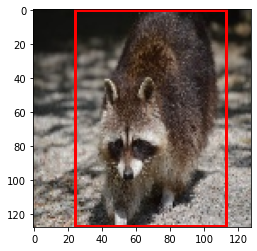

In [30]:
number = 15
im = cv2.imread(str(df_train.values[number][8]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[number][9])

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


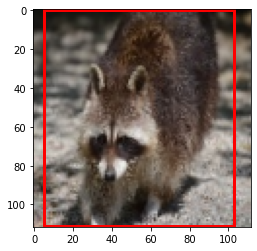

In [31]:
im, bb = transformsXY(str(df_train.values[number][8]),df_train.values[number][9],True )
show_corner_bb(im, bb)

### dataset

In [32]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [33]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [34]:
# class RacoonsDataset(Dataset):
#     def __init__(self, paths, bb, y, transforms=False):
#         self.transforms = transforms
#         self.paths = paths.values
#         self.bb = bb.values
#         self.y = y.values
#     def __len__(self):
#         return len(self.paths)
    
#     def __getitem__(self, idx):
#         path = self.paths[idx]
#         y_class = self.y[idx]
#         x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
#         x = normalize(x)
#         x = np.rollaxis(x, 2)
#         return x, y_class, y_bb

In [35]:
class RacoonsDatasetFRCNN(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]

        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        y_bb = np.asarray([y_bb])
        labels=np.ones(1) #у нас на 1 картирнку 1 енот
        x = normalize(x)
        x = np.rollaxis(x, 2)
            
        targets={}
        targets['boxes']=torch.from_numpy(y_bb).double()
        targets['labels']=torch.from_numpy(labels).type(torch.int64)
        #targets['id']=self.imgs[idx].split('.')[0]
        return torch.from_numpy(x).double(), targets

In [36]:
# train_ds = RacoonsDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
# valid_ds = RacoonsDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [37]:
train_ds = RacoonsDatasetFRCNN(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RacoonsDatasetFRCNN(X_val['new_path'],X_val['new_bb'],y_val)

In [38]:
train_ds[1]

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


(tensor([[[ 0.4685,  0.3935,  0.2969,  ..., -1.6973, -1.3670, -0.9041],
          [ 0.2582,  0.5650,  0.5037,  ..., -1.2437, -0.8929, -0.8228],
          [ 0.5627,  0.2225,  0.1218,  ..., -0.5883, -0.3343, -1.4448],
          ...,
          [ 0.7127,  0.1735, -0.4755,  ..., -1.5168, -1.4656, -1.4613],
          [ 0.8970,  0.9413,  0.3010,  ..., -1.5780, -1.5127, -1.4222],
          [ 0.3525,  0.3812, -0.2840,  ..., -1.6664, -1.5840, -1.3785]],
 
         [[ 0.6379,  0.5657,  0.4518,  ..., -1.6233, -1.2855, -0.8123],
          [ 0.3934,  0.7071,  0.6615,  ..., -1.1595, -0.8009, -0.7292],
          [ 0.7047,  0.3586,  0.2715,  ..., -0.4895, -0.2298, -1.3650],
          ...,
          [ 0.7667,  0.1466, -0.6003,  ..., -1.4037, -1.3298, -1.2977],
          [ 1.0079,  1.0015,  0.2665,  ..., -1.4630, -1.3465, -1.2428],
          [ 0.4428,  0.4199, -0.3287,  ..., -1.5205, -1.4015, -1.1747]],
 
         [[ 0.6629,  0.5647,  0.4340,  ..., -1.4636, -1.1273, -0.6562],
          [ 0.4047,  0.7170,

In [39]:
batch_size = 2
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=lambda x:list(zip(*x)))
valid_dl = DataLoader(valid_ds, batch_size=batch_size, collate_fn=lambda x:list(zip(*x)))

In [40]:
# for images, targets in train_dl:
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#     print(images[0].shape[0])
    
#     print('____')

In [41]:
device = torch.device("cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### model

In [42]:
# class BB_model(nn.Module):
#     def __init__(self):
#         super(BB_model, self).__init__()
#         resnet = models.resnet34(pretrained=True)
#         layers = list(resnet.children())[:8]
#         self.features1 = nn.Sequential(*layers[:6])
#         self.features2 = nn.Sequential(*layers[6:])
#         self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
#         self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
#     def forward(self, x):
#         x = self.features1(x)
#         x = self.features2(x)
#         x = F.relu(x)
#         x = nn.AdaptiveAvgPool2d((1,1))(x)
#         x = x.view(x.shape[0], -1)
#         return self.classifier(x), self.bb(x)

In [43]:
# model = BB_model().to(device)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)
epochs = 10

In [44]:
# def move_to(obj, device):
#     if torch.is_tensor(obj):
#         return obj.to(device)
#     elif isinstance(obj, dict):
#         res = {}
#         for k, v in obj.items():
#             res[k] = move_to(v, device)
#         return res
#     elif isinstance(obj, list):
#         res = []
#         for v in obj:
#             res.append(move_to(v, device))
#         return res
#     else:
#         raise TypeError("Invalid type for move_to")

In [45]:
model.train()
from tqdm.notebook import tqdm
for epoch in tqdm(range(1)):
    for images,targets in tqdm(train_dl):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model=model.double()
        optimizer.zero_grad()

        loss_dict = model(images, targets)
#         print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()

#         optimizer.zero_grad()
        optimizer.step()
        
    print("Loss = {:.4f} ".format(losses.item()))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


{'loss_classifier': tensor(0.7847, dtype=torch.float64, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0556, dtype=torch.float64, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1057, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0078, dtype=torch.float64, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(9.6519e+17, dtype=torch.float64, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(1.9052e+17, dtype=torch.float64, grad_fn=<DivBackward0>), 'loss_objectness': tensor(7.7494e+15, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(3.4612e+14, dtype=torch.float64, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(8113825.8452, dtype=torch.float64, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(4736446.1668, dtype=torch.float64, grad_fn=<DivBackward0>), 'loss_objectness': tensor(42165.4922, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(4483.0958, dtype=torch.float64, grad_fn=<DivBac

{'loss_classifier': tensor(0., dtype=torch.float64, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(2.3364e+08, dtype=torch.float64, grad_fn=<DivBackward0>), 'loss_objectness': tensor(566986.5625, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(863258.5029, dtype=torch.float64, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0., dtype=torch.float64, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(9.7831e+08, dtype=torch.float64, grad_fn=<DivBackward0>), 'loss_objectness': tensor(1725189., grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(1999032.5289, dtype=torch.float64, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0., dtype=torch.float64, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(8.2246e+08, dtype=torch.float64, grad_fn=<DivBackward0>), 'loss_objectness': tensor(558946.2500, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(1451857.3546, dtype=torch.float64, grad_fn=<DivBackward0

{'loss_classifier': tensor(0., dtype=torch.float64, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(3.2442e+08, dtype=torch.float64, grad_fn=<DivBackward0>), 'loss_objectness': tensor(211261.5312, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(2070640.1233, dtype=torch.float64, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0., dtype=torch.float64, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(2.1570e+08, dtype=torch.float64, grad_fn=<DivBackward0>), 'loss_objectness': tensor(182642.9219, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(193925.8266, dtype=torch.float64, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0., dtype=torch.float64, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(3.9337e+08, dtype=torch.float64, grad_fn=<DivBackward0>), 'loss_objectness': tensor(509980.3125, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(510857.5277, dtype=torch.float64, grad_fn=<DivBackwar

In [ ]:
# for i in range(epochs):
    
#     model.train()
#     total = 0
#     sum_loss = 0
#     C=1000
    
#     for images, targets in train_dl:
#         batch = images[0].shape[0]
    
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         model=model.double()
# #         print(x.shape)
# #         print(y_bb.shape)
# #         print(y_class.shape)
#         optimizer.zero_grad()

#         loss_dict = model(images, targets)
# #         print(out_bb.shape)
# #         print(out_class.shape)
#         losses = sum(loss for loss in loss_dict.values())

#         losses.backward()
#         optimizer.step()
        
#         total += batch
#         sum_loss += losses.item()
#     train_loss = sum_loss/total
    
#     # Eval
# #     model.eval()
# #     val_total = 0
# #     val_sum_loss = 0
# #     correct = 0
    
# #     for images, targets in valid_dl:
# #         batch = images[0].shape[0]
        
# #         images = list(image.to(device) for image in images)
# #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# #         loss_dict = model(images, targets)
# # #         loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

# # #         loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
# # #         loss_bb = loss_bb.sum()
# # #         loss = loss_class + loss_bb/C
# # #         _, pred = torch.max(out_class, 1)
# # #         correct += pred.eq(y_class).sum().item()
# # #         val_sum_loss += loss.item()
# # #         val_total += batch
# # #     val_loss = val_sum_loss/val_total
# # #     val_acc = correct/val_total
    
#     print("train_loss %.3f " % (train_loss))

### test

In [76]:
im = read_image('./data/raccoon-89.jpg')
im = cv2.resize(im, (int(1*128), 128))

In [74]:
train_ds[0]

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


(tensor([[[-0.6040, -0.7040, -1.0089,  ..., -1.0096, -0.9473, -0.9705],
          [-0.6359, -0.7935, -0.8929,  ..., -0.8444, -0.8429, -0.9261],
          [-0.8528, -0.7335, -0.7303,  ..., -0.7536, -0.8206, -0.9352],
          ...,
          [-0.6066, -0.7271, -0.2963,  ..., -1.8894, -1.7247, -1.5363],
          [-0.4753, -0.6719, -0.5297,  ..., -1.9749, -1.7322, -1.5255],
          [-0.8077, -0.5510, -0.7185,  ..., -1.8899, -1.7206, -1.5698]],
 
         [[-0.5218, -0.6148, -0.9304,  ..., -0.9027, -0.8652, -0.9153],
          [-0.5557, -0.7167, -0.8273,  ..., -0.7452, -0.7498, -0.8288],
          [-0.7774, -0.6603, -0.6674,  ..., -0.6585, -0.7269, -0.8441],
          ...,
          [-0.3676, -0.5033, -0.0574,  ..., -1.8897, -1.7235, -1.5636],
          [-0.2656, -0.4809, -0.3327,  ..., -1.9770, -1.7289, -1.5348],
          [-0.6580, -0.4207, -0.5979,  ..., -1.8902, -1.7170, -1.5578]],
 
         [[-0.7052, -0.8553, -1.1391,  ..., -0.8217, -0.7753, -0.8284],
          [-0.7297, -0.9001,

In [91]:
# test Dataset
test_ds = RacoonsDatasetFRCNN(pd.DataFrame([{'path':'./data/raccoon-89.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
test_dl = DataLoader(test_ds, batch_size=4, collate_fn=lambda x:list(zip(*x)))

In [98]:
test_ds[0]

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


(tensor([[[ 0.9988,  0.9988,  0.9817,  ...,  1.8379,  0.9646, -0.0801],
          [ 1.3584,  1.3413,  1.3413,  ...,  1.5639,  1.2899,  0.8276],
          [ 1.5810,  1.5639,  1.5639,  ...,  1.1700,  0.9132,  0.5707],
          ...,
          [ 1.4269,  1.3755,  1.4269,  ...,  0.9817,  1.0159,  1.0331],
          [ 1.6324,  1.6324,  1.6324,  ...,  1.1872,  1.1700,  1.1700],
          [ 1.6324,  1.6324,  1.6324,  ...,  1.1872,  1.1872,  1.1700]],
 
         [[ 1.1506,  1.1506,  1.1331,  ...,  1.7983,  0.9580, -0.0574],
          [ 1.5182,  1.5007,  1.5007,  ...,  1.5182,  1.2906,  0.8704],
          [ 1.7633,  1.7458,  1.7458,  ...,  1.1155,  0.8880,  0.6078],
          ...,
          [ 1.5882,  1.5357,  1.5882,  ...,  1.0980,  1.1331,  1.1506],
          [ 1.7983,  1.7983,  1.7983,  ...,  1.3081,  1.2906,  1.2906],
          [ 1.7983,  1.7983,  1.7983,  ...,  1.3081,  1.3081,  1.2906]],
 
         [[ 1.3328,  1.3328,  1.3154,  ...,  2.0125,  1.1934,  0.1999],
          [ 1.6988,  1.6814,

In [93]:
images = next(iter(test_dl))
images = list(image.to(device) for image in images[0])

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [94]:
images

[tensor([[[ 0.9988,  0.9988,  0.9817,  ...,  1.8379,  0.9646, -0.0801],
          [ 1.3584,  1.3413,  1.3413,  ...,  1.5639,  1.2899,  0.8276],
          [ 1.5810,  1.5639,  1.5639,  ...,  1.1700,  0.9132,  0.5707],
          ...,
          [ 1.4269,  1.3755,  1.4269,  ...,  0.9817,  1.0159,  1.0331],
          [ 1.6324,  1.6324,  1.6324,  ...,  1.1872,  1.1700,  1.1700],
          [ 1.6324,  1.6324,  1.6324,  ...,  1.1872,  1.1872,  1.1700]],
 
         [[ 1.1506,  1.1506,  1.1331,  ...,  1.7983,  0.9580, -0.0574],
          [ 1.5182,  1.5007,  1.5007,  ...,  1.5182,  1.2906,  0.8704],
          [ 1.7633,  1.7458,  1.7458,  ...,  1.1155,  0.8880,  0.6078],
          ...,
          [ 1.5882,  1.5357,  1.5882,  ...,  1.0980,  1.1331,  1.1506],
          [ 1.7983,  1.7983,  1.7983,  ...,  1.3081,  1.2906,  1.2906],
          [ 1.7983,  1.7983,  1.7983,  ...,  1.3081,  1.3081,  1.2906]],
 
         [[ 1.3328,  1.3328,  1.3154,  ...,  2.0125,  1.1934,  0.1999],
          [ 1.6988,  1.6814,

In [95]:
outputs = model(images)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:75] data. DefaultCPUAllocator: not enough memory: you tried to allocate 255897600 bytes. Buy new RAM!

In [96]:
idx = 0
sample = images[idx].permute(1, 2, 0).cpu().numpy()
boxes = outputs[idx]['boxes'].data.cpu().numpy()
scores = outputs[idx]['scores'].data.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


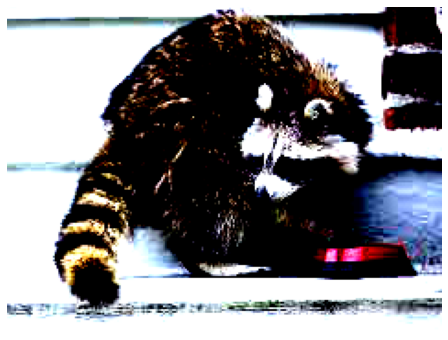

In [97]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))
for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 1)
ax.set_axis_off()
ax.imshow(sample)